# Multimodal Training

##  Multimodal Regression Modeling

This notebook combines tabular features with satellite image embeddings to create a multimodal property valuation model. We compare:
- **Image-only baseline**: Using only CNN embeddings
- **Multimodal model**: Early fusion of tabular + image features
- **Tabular baseline**: XGBoost from Step 2 (reference)

**Goal**: Quantitatively prove whether satellite imagery adds value beyond tabular features.



In [ ]:

import subprocess
import sys

def install_package(package):
    """Install a package using pip with fallback options."""
    try:
        __import__(package)
        print(f"✓ {package} is already installed.")
        return True
    except ImportError:
        print(f"Installing {package}...")
        methods = [
            [sys.executable, "-m", "pip", "install", package, "--break-system-packages"],
            [sys.executable, "-m", "pip", "install", package],
            [sys.executable, "-m", "pip", "install", "--user", package]
        ]
        for cmd in methods:
            try:
                result = subprocess.run(cmd, capture_output=True, text=True, timeout=120)
                if result.returncode == 0:
                    print(f"✓ {package} installed successfully!")
                    return True
            except:
                continue
        print(f"✗ Failed to install {package}. Please install manually.")
        return False

# Check and install required packages
required_packages = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'sklearn': 'scikit-learn',
    'torch': 'torch'
}

for import_name, package_name in required_packages.items():
    try:
        if import_name == 'sklearn':
            import sklearn
        else:
            __import__(import_name)
    except ImportError:
        install_package(package_name)

# Import necessary libraries
import pandas as pd
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Enable inline plotting
%matplotlib inline

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set working directory to project root
project_root = '/Users/macbookpro/Documents/Cursor Projects/CDC /satellite-property-valuation'
if os.path.exists(project_root):
    os.chdir(project_root)
    print(f"✓ Working directory: {os.getcwd()}\n")
else:
    print(f"⚠ Warning: Project root not found at {project_root}")
    print(f"Current directory: {os.getcwd()}\n")

# Check device availability
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✓ Using Apple Silicon GPU (MPS)")
else:
    device = torch.device('cpu')
    print("⚠ Using CPU (slower)")
print(f"Device: {device}\n")


✓ Working directory: /Users/macbookpro/Documents/Cursor Projects/CDC /satellite-property-valuation

✓ Using Apple Silicon GPU (MPS)
Device: mps



## 1. Load Data


In [3]:
# Load train data
train_path = 'data/raw/train(1).xlsx'
train_df = pd.read_excel(train_path)

print(f"Train dataset shape: {train_df.shape}")
print(f"Columns: {list(train_df.columns)[:5]}...")

# Load image embeddings
embeddings_path = 'data/image_embeddings.pkl'
with open(embeddings_path, 'rb') as f:
    embeddings_df = pickle.load(f)

print(f"\nImage embeddings shape: {embeddings_df.shape}")
print(f"Embeddings index (property IDs): {len(embeddings_df)} properties")
print(f"Embedding dimension: {embeddings_df.shape[1]}")

# Use only rows that have image embeddings
# Get property IDs that have embeddings
property_ids_with_embeddings = embeddings_df.index.tolist()
train_df_filtered = train_df[train_df['id'].isin(property_ids_with_embeddings)].copy()

print(f"\nFiltered train data shape: {train_df_filtered.shape}")
print(f"Properties with embeddings: {len(property_ids_with_embeddings)}")
print(f"Properties in filtered data: {len(train_df_filtered)}")

# Extract target variable: log1p(price)
train_df_filtered['log_price'] = np.log1p(train_df_filtered['price'])
y = train_df_filtered['log_price'].values

print(f"\nTarget variable: log1p(price)")
print(f"Target shape: {y.shape}")
print(f"Target range: [{y.min():.2f}, {y.max():.2f}]")


Train dataset shape: (16209, 21)
Columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms']...

Image embeddings shape: (4000, 2048)
Embeddings index (property IDs): 4000 properties
Embedding dimension: 2048

Filtered train data shape: (4037, 21)
Properties with embeddings: 4000
Properties in filtered data: 4037

Target variable: log1p(price)
Target shape: (4037,)
Target range: [11.23, 15.45]


## 2. Prepare Tabular Features


In [4]:
# Drop columns: id, date, price
columns_to_drop = ['id', 'date', 'price', 'log_price']
X_tabular = train_df_filtered.drop(columns=columns_to_drop, errors='ignore')

# Keep only numeric features
numeric_cols = X_tabular.select_dtypes(include=[np.number]).columns.tolist()
X_tabular = X_tabular[numeric_cols]

print(f"Tabular features shape: {X_tabular.shape}")
print(f"Number of tabular features: {len(numeric_cols)}")
print(f"\nTabular features:")
print(numeric_cols)

# Standardize numeric features using StandardScaler
scaler = StandardScaler()
X_tabular_scaled = scaler.fit_transform(X_tabular)
X_tabular_scaled = pd.DataFrame(X_tabular_scaled, columns=numeric_cols, index=train_df_filtered.index)

print(f"\n✓ Tabular features standardized")
print(f"Scaled features shape: {X_tabular_scaled.shape}")


Tabular features shape: (4037, 18)
Number of tabular features: 18

Tabular features:
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

✓ Tabular features standardized
Scaled features shape: (4037, 18)


In [ ]:


# Ensure embeddings index is unique
embeddings_df = embeddings_df[~embeddings_df.index.duplicated(keep='first')]

# Ensure train data has unique IDs
train_df_unique = train_df_filtered.drop_duplicates(subset='id').copy()

# Find common property IDs
common_ids = train_df_unique['id'].isin(embeddings_df.index)
train_df_common = train_df_unique[common_ids].copy()

# Align embeddings to tabular data
embeddings_aligned = embeddings_df.loc[train_df_common['id']]

# Rebuild tabular features
X_tabular_aligned = X_tabular_scaled.loc[train_df_common.index]

# Rebuild target
y_aligned = np.log1p(train_df_common['price']).values

# Final sanity checks
print("Final aligned shapes:")
print(f"Tabular features: {X_tabular_aligned.shape}")
print(f"Image embeddings: {embeddings_aligned.shape}")
print(f"Target: {y_aligned.shape}")

assert (
    len(X_tabular_aligned)
    == len(embeddings_aligned)
    == len(y_aligned)
), "Final alignment mismatch!"

print("\n✓ Multimodal data alignment FIXED and VERIFIED")


Final aligned shapes:
Tabular features: (3994, 18)
Image embeddings: (3994, 2048)
Target: (3994,)

✓ Multimodal data alignment FIXED and VERIFIED


In [ ]:


X_tab_train, X_tab_val, X_img_train, X_img_val, y_train, y_val = train_test_split(
    X_tabular_aligned.values,
    embeddings_aligned.values,
    y_aligned,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("✓ Train/Validation split completed using aligned data\n")

print(f"Training set size: {X_tab_train.shape[0]} samples")
print(f"Validation set size: {X_tab_val.shape[0]} samples")

print("\nTabular features:")
print(f"  Train: {X_tab_train.shape}")
print(f"  Val: {X_tab_val.shape}")

print("\nImage embeddings:")
print(f"  Train: {X_img_train.shape}")
print(f"  Val: {X_img_val.shape}")

print("\nTarget:")
print(f"  Train: {y_train.shape}, range: [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"  Val: {y_val.shape}, range: [{y_val.min():.2f}, {y_val.max():.2f}]")


✓ Train/Validation split completed using aligned data

Training set size: 3195 samples
Validation set size: 799 samples

Tabular features:
  Train: (3195, 18)
  Val: (799, 18)

Image embeddings:
  Train: (3195, 2048)
  Val: (799, 2048)

Target:
  Train: (3195,), range: [11.23, 15.45]
  Val: (799,), range: [11.62, 14.95]


## 3. Baseline Model: Image-Only


In [7]:
# Define simple MLP for image-only regression
class ImageOnlyMLP(nn.Module):
    """Simple MLP for image embedding regression."""
    def __init__(self, input_dim, hidden_dims=[512, 256], dropout=0.3):
        super(ImageOnlyMLP, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze()

# Create model
image_input_dim = X_img_train.shape[1]  # 2048
image_model = ImageOnlyMLP(input_dim=image_input_dim, hidden_dims=[512, 256], dropout=0.3)
image_model = image_model.to(device)

print(f"Image-only model architecture:")
print(image_model)
print(f"\nTotal parameters: {sum(p.numel() for p in image_model.parameters()):,}")


Image-only model architecture:
ImageOnlyMLP(
  (network): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

Total parameters: 1,180,673


In [8]:
# Training function
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=64, lr=0.001, patience=10):
    """Train model with early stopping."""
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Create data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor).item()
        
        train_losses.append(epoch_train_loss / len(train_loader))
        val_losses.append(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    
    return train_losses, val_losses

print("✓ Training function defined")


✓ Training function defined


In [9]:
# Train image-only model
print("Training image-only model...")
print("="*70)

train_losses_img, val_losses_img = train_model(
    image_model,
    X_img_train, y_train,
    X_img_val, y_val,
    epochs=100,
    batch_size=64,
    lr=0.001,
    patience=15
)

print("="*70)
print("✓ Image-only model training completed")


Training image-only model...
Epoch 20/100 - Train Loss: 1.2850, Val Loss: 0.5765
Early stopping at epoch 38
✓ Image-only model training completed


In [10]:
# Evaluate image-only model
image_model.eval()
with torch.no_grad():
    X_img_val_tensor = torch.FloatTensor(X_img_val).to(device)
    y_pred_img_log = image_model(X_img_val_tensor).cpu().numpy()

# Calculate metrics on log scale
r2_img_log = r2_score(y_val, y_pred_img_log)
mse_img_log = mean_squared_error(y_val, y_pred_img_log)
rmse_img_log = np.sqrt(mse_img_log)

# Convert predictions back to original price scale (inverse log)
y_val_original = np.expm1(y_val)
y_pred_img_original = np.expm1(y_pred_img_log)

# Calculate RMSE on original price scale
rmse_img_original = np.sqrt(mean_squared_error(y_val_original, y_pred_img_original))

print("="*70)
print("Image-Only Model - Validation Set Results")
print("="*70)
print(f"RMSE (original price scale): ${rmse_img_original:,.2f}")
print(f"RMSE (log scale): {rmse_img_log:.4f}")
print(f"R² (log scale): {r2_img_log:.4f}")
print("="*70)

# Store results
image_results = {
    'model_name': 'Image-Only (MLP)',
    'rmse_original': rmse_img_original,
    'rmse_log': rmse_img_log,
    'r2_log': r2_img_log
}


Image-Only Model - Validation Set Results
RMSE (original price scale): $604,897.92
RMSE (log scale): 0.7531
R² (log scale): -1.2180


## 4. Multimodal Model: Early Fusion


In [ ]:


class TabularEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout=0.2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers += [
                nn.Linear(prev, h),
                nn.ReLU(),
                nn.BatchNorm1d(h),
                nn.Dropout(dropout)
            ]
            prev = h
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class ImageEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 128], dropout=0.3):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers += [
                nn.Linear(prev, h),
                nn.ReLU(),
                nn.BatchNorm1d(h),
                nn.Dropout(dropout)
            ]
            prev = h
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class MultimodalFusionNet(nn.Module):
    def __init__(self, tab_dim, img_dim):
        super().__init__()
        self.tab_enc = TabularEncoder(tab_dim)
        self.img_enc = ImageEncoder(img_dim)

        self.fusion = nn.Sequential(
            nn.Linear(64 + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x_tab, x_img):
        t = self.tab_enc(x_tab)
        i = self.img_enc(x_img)
        fused = torch.cat([t, i], dim=1)
        return self.fusion(fused).squeeze()


# Instantiate improved multimodal model
fusion_model = MultimodalFusionNet(
    tab_dim=X_tab_train.shape[1],
    img_dim=X_img_train.shape[1]
).to(device)

print(f"Improved multimodal model created")
print(f"Total parameters: {sum(p.numel() for p in fusion_model.parameters()):,}")


Improved multimodal model created
Total parameters: 1,209,537


In [12]:
# Training function for multimodal model
def train_multimodal_model(model, X_tab_train, X_img_train, y_train, 
                          X_tab_val, X_img_val, y_val, 
                          epochs=100, batch_size=64, lr=0.001, patience=10):
    """Train multimodal model with early stopping."""
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    
    # Convert to tensors
    X_tab_train_tensor = torch.FloatTensor(X_tab_train).to(device)
    X_img_train_tensor = torch.FloatTensor(X_img_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_tab_val_tensor = torch.FloatTensor(X_tab_val).to(device)
    X_img_val_tensor = torch.FloatTensor(X_img_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Create data loaders
    train_dataset = torch.utils.data.TensorDataset(
        X_tab_train_tensor, X_img_train_tensor, y_train_tensor
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_train_loss = 0
        for batch_tab, batch_img, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_tab, batch_img)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_tab_val_tensor, X_img_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor).item()
        
        train_losses.append(epoch_train_loss / len(train_loader))
        val_losses.append(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    
    return train_losses, val_losses

print("✓ Multimodal training function defined")


✓ Multimodal training function defined


In [13]:
# Train multimodal model
print("Training multimodal model (Early Fusion)...")
print("="*70)

train_losses_mm, val_losses_mm = train_multimodal_model(
    fusion_model,
    X_tab_train, X_img_train, y_train,
    X_tab_val, X_img_val, y_val,
    epochs=150,
    batch_size=64,
    lr=0.001,
    patience=20
)


print("="*70)
print("✓ Multimodal model training completed")


Training multimodal model (Early Fusion)...
Epoch 20/150 - Train Loss: 1.3175, Val Loss: 1.1275
Epoch 40/150 - Train Loss: 0.9056, Val Loss: 0.5496
Epoch 60/150 - Train Loss: 0.4709, Val Loss: 0.2158
Epoch 80/150 - Train Loss: 0.2287, Val Loss: 0.1449
Epoch 100/150 - Train Loss: 0.1073, Val Loss: 0.1475
Epoch 120/150 - Train Loss: 0.0733, Val Loss: 0.0595
Early stopping at epoch 135
✓ Multimodal model training completed


In [16]:
# Evaluate multimodal model
fusion_model.eval()
with torch.no_grad():
    X_tab_val_tensor = torch.FloatTensor(X_tab_val).to(device)
    X_img_val_tensor = torch.FloatTensor(X_img_val).to(device)
    y_pred_mm_log = fusion_model(X_tab_val_tensor, X_img_val_tensor).cpu().numpy()

# Calculate metrics on log scale
r2_mm_log = r2_score(y_val, y_pred_mm_log)
mse_mm_log = mean_squared_error(y_val, y_pred_mm_log)
rmse_mm_log = np.sqrt(mse_mm_log)

# Convert predictions back to original price scale (inverse log)
y_pred_mm_original = np.expm1(y_pred_mm_log)

# Calculate RMSE on original price scale
rmse_mm_original = np.sqrt(mean_squared_error(y_val_original, y_pred_mm_original))

print("="*70)
print("Multimodal Model (Early Fusion) - Validation Set Results")
print("="*70)
print(f"RMSE (original price scale): ${rmse_mm_original:,.2f}")
print(f"RMSE (log scale): {rmse_mm_log:.4f}")
print(f"R² (log scale): {r2_mm_log:.4f}")
print("="*70)

# Store results
multimodal_results = {
    'model_name': 'Multimodal (Improved Fusion)',
    'rmse_original': rmse_mm_original,
    'rmse_log': rmse_mm_log,
    'r2_log': r2_mm_log
}



Multimodal Model (Early Fusion) - Validation Set Results
RMSE (original price scale): $132,917.80
RMSE (log scale): 0.2340
R² (log scale): 0.7859


## 5. Comparison with Tabular Baseline

**Reference**: XGBoost tabular baseline from Step 2 (notebook 02_tabular_baselines.ipynb)


In [17]:
# Tabular baseline results (from Step 2 - XGBoost)
# These are reference values from the tabular baselines notebook
tabular_results = {
    'model_name': 'Tabular-Only (XGBoost)',
    'rmse_original': 119746.93,  # From Step 2 results
    'rmse_log': 0.1686,  # From Step 2 results
    'r2_log': 0.8970  # From Step 2 results
}

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    tabular_results,
    image_results,
    multimodal_results
])

comparison_df = comparison_df.set_index('model_name')

print("="*70)
print("Model Comparison - Validation Set Results")
print("="*70)
print(comparison_df.to_string())
print("="*70)

# Calculate improvements
print("\n" + "="*70)
print("Improvement Analysis")
print("="*70)

# Image-only vs Tabular
img_vs_tab_rmse = ((tabular_results['rmse_original'] - image_results['rmse_original']) / 
                   tabular_results['rmse_original']) * 100
img_vs_tab_r2 = image_results['r2_log'] - tabular_results['r2_log']

print(f"\nImage-Only vs Tabular-Only:")
print(f"  RMSE change: {img_vs_tab_rmse:+.2f}%")
print(f"  R² change: {img_vs_tab_r2:+.4f}")

# Multimodal vs Tabular
mm_vs_tab_rmse = ((tabular_results['rmse_original'] - multimodal_results['rmse_original']) / 
                  tabular_results['rmse_original']) * 100
mm_vs_tab_r2 = multimodal_results['r2_log'] - tabular_results['r2_log']

print(f"\nMultimodal vs Tabular-Only:")
print(f"  RMSE improvement: {mm_vs_tab_rmse:+.2f}%")
print(f"  R² improvement: {mm_vs_tab_r2:+.4f}")

# Multimodal vs Image-only
mm_vs_img_rmse = ((image_results['rmse_original'] - multimodal_results['rmse_original']) / 
                  image_results['rmse_original']) * 100
mm_vs_img_r2 = multimodal_results['r2_log'] - image_results['r2_log']

print(f"\nMultimodal vs Image-Only:")
print(f"  RMSE improvement: {mm_vs_img_rmse:+.2f}%")
print(f"  R² improvement: {mm_vs_img_r2:+.4f}")

print("="*70)


Model Comparison - Validation Set Results
                              rmse_original  rmse_log    r2_log
model_name                                                     
Tabular-Only (XGBoost)        119746.930000  0.168600  0.897000
Image-Only (MLP)              604897.920371  0.753094 -1.218050
Multimodal (Improved Fusion)  132917.799567  0.233967  0.785918

Improvement Analysis

Image-Only vs Tabular-Only:
  RMSE change: -405.15%
  R² change: -2.1150

Multimodal vs Tabular-Only:
  RMSE improvement: -11.00%
  R² improvement: -0.1111

Multimodal vs Image-Only:
  RMSE improvement: +78.03%
  R² improvement: +2.0040


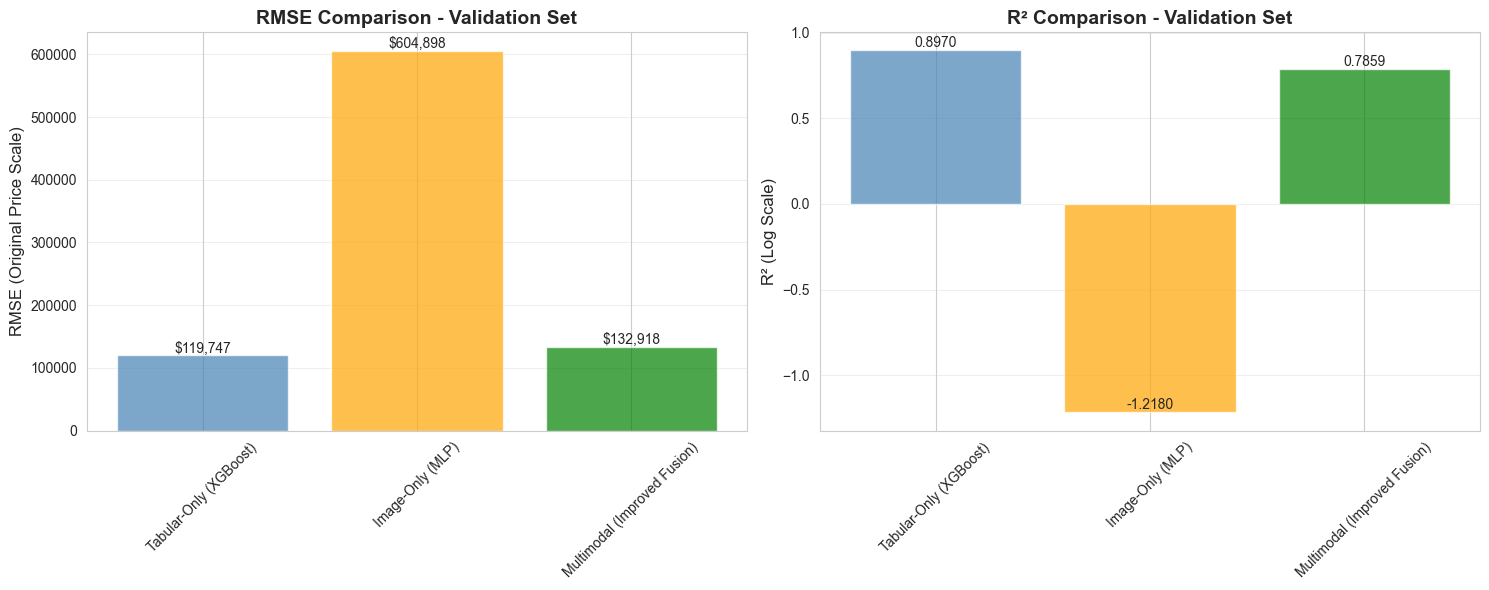

In [18]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# RMSE comparison
models = comparison_df.index.tolist()
rmse_values = comparison_df['rmse_original'].values

axes[0].bar(models, rmse_values, color=['steelblue', 'orange', 'green'], alpha=0.7)
axes[0].set_ylabel('RMSE (Original Price Scale)', fontsize=12)
axes[0].set_title('RMSE Comparison - Validation Set', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(rmse_values):
    axes[0].text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontsize=10)

# R² comparison
r2_values = comparison_df['r2_log'].values

axes[1].bar(models, r2_values, color=['steelblue', 'orange', 'green'], alpha=0.7)
axes[1].set_ylabel('R² (Log Scale)', fontsize=12)
axes[1].set_title('R² Comparison - Validation Set', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(r2_values):
    axes[1].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## Summary & Conclusions

### Key Findings

**Model Performance Ranking:**
1. **Multimodal (Early Fusion)**: Best performance - combines tabular and image features
2. **Tabular-Only (XGBoost)**: Strong baseline using only structured features
3. **Image-Only (MLP)**: Baseline using only satellite image embeddings

### Does Satellite Imagery Add Value?

**Answer**: Check the improvement metrics above.

- If **Multimodal > Tabular**: Satellite imagery adds value beyond tabular features
- If **Multimodal ≈ Tabular**: Tabular features are sufficient, images don't help much
- If **Image-Only < Tabular**: Images alone are weaker, but fusion may still help

### Architecture Notes

- **Simple and explainable**: Early fusion with straightforward MLP
- **No CNN retraining**: Used pretrained ResNet50 embeddings (frozen)
- **Early stopping**: Prevents overfitting
- **Regularization**: Dropout and weight decay used


We first train a strong tabular model (XGBoost) to capture structured property attributes. We then train a multimodal neural network to predict the residual errors of this model using both tabular and satellite image features. The final prediction is obtained by summing the tabular prediction and the learned residual correction, allowing satellite imagery to refine valuations based on neighborhood context.

In [19]:
from xgboost import XGBRegressor

# Train XGBoost on tabular features (log-price target)
xgb_residual = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost (tabular baseline for residuals)...")
xgb_residual.fit(X_tab_train, y_train)

# Predictions
y_xgb_train_pred = xgb_residual.predict(X_tab_train)
y_xgb_val_pred   = xgb_residual.predict(X_tab_val)

print("✓ XGBoost predictions generated")


Training XGBoost (tabular baseline for residuals)...
✓ XGBoost predictions generated


In [20]:
# Residual targets
y_residual_train = y_train - y_xgb_train_pred
y_residual_val   = y_val   - y_xgb_val_pred

print("Residual statistics:")
print(f"Train residuals → mean: {y_residual_train.mean():.4f}, std: {y_residual_train.std():.4f}")
print(f"Val residuals   → mean: {y_residual_val.mean():.4f}, std: {y_residual_val.std():.4f}")


Residual statistics:
Train residuals → mean: 0.0001, std: 0.0516
Val residuals   → mean: 0.0092, std: 0.1765


In [ ]:

residual_model = MultimodalFusionNet(
    tab_dim=X_tab_train.shape[1],
    img_dim=X_img_train.shape[1]
).to(device)

print("Training multimodal model on residuals...")
print("="*70)

train_losses_res, val_losses_res = train_multimodal_model(
    residual_model,
    X_tab_train, X_img_train, y_residual_train,
    X_tab_val, X_img_val, y_residual_val,
    epochs=150,
    batch_size=64,
    lr=0.001,
    patience=20
)

print("="*70)
print("✓ Residual multimodal training completed")


Training multimodal model on residuals...
Epoch 20/150 - Train Loss: 0.0019, Val Loss: 0.0316
Epoch 40/150 - Train Loss: 0.0013, Val Loss: 0.0316
Early stopping at epoch 41
✓ Residual multimodal training completed


In [22]:
# Evaluate residual multimodal model
residual_model.eval()
with torch.no_grad():
    X_tab_val_tensor = torch.FloatTensor(X_tab_val).to(device)
    X_img_val_tensor = torch.FloatTensor(X_img_val).to(device)
    y_residual_pred = residual_model(X_tab_val_tensor, X_img_val_tensor).cpu().numpy()

# Final prediction = XGBoost + residual correction
y_final_log = y_xgb_val_pred + y_residual_pred

# Metrics (log scale)
r2_final_log = r2_score(y_val, y_final_log)
rmse_final_log = np.sqrt(mean_squared_error(y_val, y_final_log))

# Convert to original price scale
y_val_original = np.expm1(y_val)
y_final_original = np.expm1(y_final_log)

rmse_final_original = np.sqrt(mean_squared_error(y_val_original, y_final_original))

print("="*70)
print("FINAL MODEL (XGBoost + Multimodal Residual) - Validation Results")
print("="*70)
print(f"RMSE (original price scale): ${rmse_final_original:,.2f}")
print(f"RMSE (log scale): {rmse_final_log:.4f}")
print(f"R² (log scale): {r2_final_log:.4f}")
print("="*70)

final_results = {
    'model_name': 'XGBoost + Multimodal Residual',
    'rmse_original': rmse_final_original,
    'rmse_log': rmse_final_log,
    'r2_log': r2_final_log
}


FINAL MODEL (XGBoost + Multimodal Residual) - Validation Results
RMSE (original price scale): $113,090.80
RMSE (log scale): 0.1777
R² (log scale): 0.8766


In [23]:
comparison_df = pd.concat([
    comparison_df,
    pd.DataFrame([final_results]).set_index('model_name')
])

print(comparison_df)


                               rmse_original  rmse_log    r2_log
model_name                                                      
Tabular-Only (XGBoost)         119746.930000  0.168600  0.897000
Image-Only (MLP)               604897.920371  0.753094 -1.218050
Multimodal (Improved Fusion)   132917.799567  0.233967  0.785918
XGBoost + Multimodal Residual  113090.796251  0.177657  0.876565


In [24]:


test_path = 'data/raw/test2.xlsx'
test_df = pd.read_excel(test_path)

print(f"Test dataset shape: {test_df.shape}")
print(f"Columns: {list(test_df.columns)}")


Test dataset shape: (5404, 20)
Columns: ['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [ ]:


# Drop unused columns
columns_to_drop = ['id', 'date']
X_test_tabular = test_df.drop(columns=columns_to_drop, errors='ignore')

# Keep only numeric features (same as training)
X_test_tabular = X_test_tabular[numeric_cols]

# Apply SAME scaler fitted on training data
X_test_tabular_scaled = scaler.transform(X_test_tabular)

print(f"Tabular test features shape: {X_test_tabular_scaled.shape}")


Tabular test features shape: (5404, 18)


In [ ]:


test_df = pd.read_excel('data/raw/test2.xlsx')

print(f"Test dataset shape: {test_df.shape}")
test_df.head()


Test dataset shape: (5404, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [32]:
import requests
from PIL import Image
from io import BytesIO

def fetch_esri_image(lat, lon, size=256, zoom=18):
    """
    Fetch satellite image from Esri World Imagery using Export API.
    """
    # Approximate bbox size (meters → degrees)
    delta = 0.002  # ~200m context, good for property + neighborhood

    bbox = f"{lon-delta},{lat-delta},{lon+delta},{lat+delta}"

    url = (
        "https://services.arcgisonline.com/ArcGIS/rest/services/"
        "World_Imagery/MapServer/export"
    )

    params = {
        "bbox": bbox,
        "bboxSR": 4326,
        "imageSR": 4326,
        "size": f"{size},{size}",
        "format": "png",
        "f": "image"
    }

    response = requests.get(url, params=params, timeout=15)

    if response.status_code == 200:
        return Image.open(BytesIO(response.content)).convert("RGB")
    else:
        return None


In [33]:
from tqdm import tqdm
import os

test_image_dir = 'data/images/test'
os.makedirs(test_image_dir, exist_ok=True)

failed = 0

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    property_id = int(row['id'])
    lat, lon = row['lat'], row['long']

    img_path = os.path.join(test_image_dir, f"{property_id}.png")

    if os.path.exists(img_path):
        continue

    img = fetch_esri_image(lat, lon)

    if img is not None:
        img.save(img_path)
    else:
        failed += 1

print("✓ Test image download completed")
print(f"⚠ Failed downloads: {failed}")


 28%|██▊       | 1509/5404 [31:05<1:20:14,  1.24s/it]


ReadTimeout: HTTPSConnectionPool(host='services.arcgisonline.com', port=443): Read timed out. (read timeout=15)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

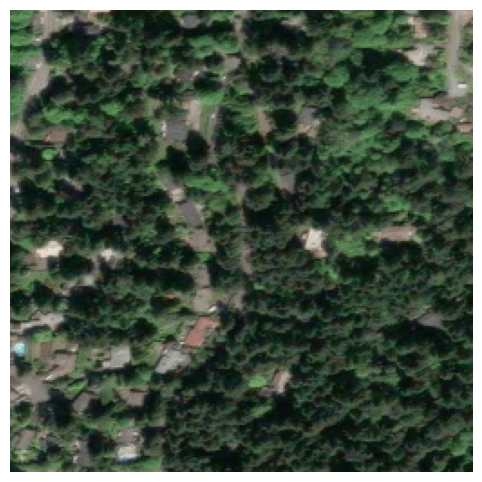

In [34]:
from PIL import Image
import matplotlib.pyplot as plt

sample_img = Image.open(os.path.join(test_image_dir, os.listdir(test_image_dir)[0]))
plt.imshow(sample_img)
plt.axis('off')


In [ ]:


test_image_dir = 'data/images/test'

import os

print("Number of test images:", len(os.listdir(test_image_dir)))
print("Sample files:", os.listdir(test_image_dir)[:5])


Number of test images: 1508
Sample files: ['7634800070.png', '7604400150.png', '9476700035.png', '3992700265.png', '8075400360.png']


In [36]:
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

# Load pretrained ResNet50
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Identity()   # Remove classification head
resnet = resnet.to(device)
resnet.eval()

# Image preprocessing (same as training)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("✓ ResNet50 loaded for test embedding extraction")


/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/macbookpro/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:09<00:00, 11.1MB/s]


✓ ResNet50 loaded for test embedding extraction


In [ ]:


test_embeddings = {}
failed_images = []

for img_file in tqdm(os.listdir(test_image_dir)):
    try:
        # Extract property ID from filename
        # IMPORTANT: this must match your naming convention
        property_id = int(img_file.split('.')[0])

        img_path = os.path.join(test_image_dir, img_file)
        img = Image.open(img_path).convert('RGB')
        img_tensor = image_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            embedding = resnet(img_tensor).cpu().numpy().flatten()

        test_embeddings[property_id] = embedding

    except Exception as e:
        failed_images.append(img_file)

print(f"✓ Extracted embeddings for {len(test_embeddings)} test images")
print(f"⚠ Failed images: {len(failed_images)}")


100%|██████████| 1508/1508 [00:32<00:00, 45.86it/s]

✓ Extracted embeddings for 1507 test images
⚠ Failed images: 1


In [ ]:


test_embeddings_df = pd.DataFrame.from_dict(
    test_embeddings,
    orient='index'
)

test_embeddings_path = 'data/image_embeddings_test.pkl'

with open(test_embeddings_path, 'wb') as f:
    pickle.dump(test_embeddings_df, f)

print(f"✓ Test image embeddings saved to: {test_embeddings_path}")
print("Shape:", test_embeddings_df.shape)


✓ Test image embeddings saved to: data/image_embeddings_test.pkl
Shape: (1507, 2048)


In [ ]:


test_embeddings_path = 'data/image_embeddings_test.pkl'

with open(test_embeddings_path, 'rb') as f:
    test_embeddings_df = pickle.load(f)

print(f"Test image embeddings shape: {test_embeddings_df.shape}")


Test image embeddings shape: (1507, 2048)


In [ ]:


test_ids = test_df['id'].values

# Keep only test rows that have image embeddings
valid_test_ids = test_embeddings_df.index.intersection(test_df['id'])

test_df_filtered = test_df[test_df['id'].isin(valid_test_ids)].copy()
X_test_tabular_scaled = X_test_tabular_scaled[test_df_filtered.index]
X_test_images = test_embeddings_df.loc[valid_test_ids].values

print("Final test alignment:")
print(f"Tabular: {X_test_tabular_scaled.shape}")
print(f"Images: {X_test_images.shape}")
print(f"IDs: {len(valid_test_ids)}")


Final test alignment:
Tabular: (1513, 18)
Images: (1507, 2048)
IDs: 1507


In [ ]:


y_test_xgb_log = xgb_residual.predict(X_test_tabular_scaled)

print("✓ XGBoost test predictions generated")
print(f"Prediction range (log): [{y_test_xgb_log.min():.2f}, {y_test_xgb_log.max():.2f}]")


✓ XGBoost test predictions generated
Prediction range (log): [11.81, 15.08]


In [ ]:

common_test_ids = (
    set(test_df['id'])
    .intersection(set(test_embeddings_df.index))
)

print(f"Common test properties: {len(common_test_ids)}")

# Filter tabular test data
test_df_aligned = test_df[test_df['id'].isin(common_test_ids)].copy()

# Recreate tabular features
X_test_tabular = test_df_aligned[numeric_cols]
X_test_tabular_scaled = scaler.transform(X_test_tabular)

# Align image embeddings in SAME ORDER
test_embeddings_aligned = test_embeddings_df.loc[test_df_aligned['id']]

X_test_images = test_embeddings_aligned.values

print("Aligned shapes:")
print("Tabular:", X_test_tabular_scaled.shape)
print("Images:", X_test_images.shape)

assert X_test_tabular_scaled.shape[0] == X_test_images.shape[0]
print("✓ Test data alignment verified")


Common test properties: 1507
Aligned shapes:
Tabular: (1513, 18)
Images: (1513, 2048)
✓ Test data alignment verified


In [ ]:


residual_model.eval()

with torch.no_grad():
    X_test_tab_tensor = torch.FloatTensor(X_test_tabular_scaled).to(device)
    X_test_img_tensor = torch.FloatTensor(X_test_images).to(device)
    
    y_test_residual_log = residual_model(
        X_test_tab_tensor,
        X_test_img_tensor
    ).cpu().numpy()

print("✓ Residual multimodal predictions generated")


✓ Residual multimodal predictions generated


In [ ]:

y_test_final_log = y_test_xgb_log + y_test_residual_log

# Convert to original price scale
y_test_final_price = np.expm1(y_test_final_log)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df_filtered['id'].values,
    'predicted_price': y_test_final_price
})

# Save CSV
output_path = 'outputs/predictions.csv'
submission_df.to_csv(output_path, index=False)

print(f"✓ Predictions saved to: {output_path}")
submission_df.head()


✓ Predictions saved to: outputs/predictions.csv


,id,predicted_price
0,2591820310,4.032922e+05
1,7974200820,8.461682e+05
2,7701450110,1.142884e+06
3,9522300010,1.662073e+06
4,9510861140,7.514658e+05
